# Reading data from the Zarr stores

We'll use 
- [Pandas](https://pandas.pydata.org/docs/) for reading a (simple) catalog of the available data sets.
- [Xarray](https://docs.xarray.dev/en/stable/index.html) with the [Zarr](https://zarr.readthedocs.io/en/stable/) engine to load individual datasets.
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [Matplotlib](https://matplotlib.org/stable/index.html) for creating maps.
- [Xoak](https://xoak.readthedocs.io/) for selecting locations from the curvilinear coordinate fields in Xarray datasets.
- [Xarray's to Pandas methods](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.to_dataframe.html) for and some calendar hack in Pandas for aligning time series across model runs.

## Imports

In [1]:
import xarray as xr
import xoak
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import cartopy

## Parameters

In [2]:
data_path = "/home/jovyan/shared_materials/climattr_data_please-dont-copy/zarr/"

lat_poi = 54.635260  # halfway to Langeland and Aeroe
lon_poi = 10.449839

## Get the catalog and set an index

In [3]:
catalog = pd.read_csv(Path(data_path) / "catalog.csv")
catalog = catalog.set_index(["domain_resolution", "gcm", "rcm", "variable"])
catalog

zarr_name
domain_resolution gcm                   rcm                   variable                                                   
AFR-22            CCCma-CanESM2         CCCma-CanRCM4         pr               pr_AFR-22_CCCma-CanESM2_CCCma-CanRCM4.zarr
                  MOHC-HadGEM2-ES       CLMcom-KIT-CCLM5-0-15 pr        pr_AFR-22_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-1...
                  MPI-M-MPI-ESM-LR      CLMcom-KIT-CCLM5-0-15 pr        pr_AFR-22_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-...
                                        GERICS-REMO2015       pr          pr_AFR-22_MPI-M-MPI-ESM-LR_GERICS-REMO2015.zarr
                  NCC-NorESM1-M         CLMcom-KIT-CCLM5-0-15 pr        pr_AFR-22_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0-15....
                                        GERICS-REMO2015       pr             pr_AFR-22_NCC-NorESM1-M_GERICS-REMO2015.zarr
EUR-11            CCCma-CanESM2         CLMcom-CCLM4-8-17     pr           pr_EUR-11_CCCma-CanESM2_CLMcom-CCLM4-8-17.zarr
                  CNRM-CERFACS-CNRM-CM5 CNRM-ALADIN63         pr        pr_EUR-11_CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63....
                  IPSL-IPSL-CM5A-MR     DMI-HIRHAM5           pr             pr_EUR-11_IPSL-IPSL-CM5A-MR_DMI-HIRHAM5.zarr
                  MIROC-MIROC5          UHOH-WRF361H          pr                 pr_EUR-11_MIROC-MIROC5_UHOH-WRF361H.zarr
                  MOHC-HadGEM2-ES       KNMI-RACMO22E         pr             pr_EUR-11_MOHC-HadGEM2-ES_KNMI-RACMO22E.zarr
                  MPI-M-MPI-ESM-LR      DMI-HIRHAM5           pr              pr_EUR-11_MPI-M-MPI-ESM-LR_DMI-HIRHAM5.zarr
                                        MPI-CSC-REMO2009      pr         pr_EUR-11_MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009.zarr
                  NCC-NorESM1-M         SMHI-RCA4             pr                   pr_EUR-11_NCC-NorESM1-M_SMHI-RCA4.zarr
AFR-22            CCCma-CanESM2         CCCma-CanRCM4         tasmax       tasmax_AFR-22_CCCma-CanESM2_CCCma-CanRCM4.zarr
                  MOHC-HadGEM2-ES       CLMcom-KIT-CCLM5-0-15 tasmax    tasmax_AFR-22_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5...
                  MPI-M-MPI-ESM-LR      CLMcom-KIT-CCLM5-0-15 tasmax    tasmax_AFR-22_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM...
                                        GERICS-REMO2015       tasmax    tasmax_AFR-22_MPI-M-MPI-ESM-LR_GERICS-REMO2015...
                  NCC-NorESM1-M         CLMcom-KIT-CCLM5-0-15 tasmax    tasmax_AFR-22_NCC-NorESM1-M_CLMcom-KIT-CCLM5-0...
                                        GERICS-REMO2015       tasmax     tasmax_AFR-22_NCC-NorESM1-M_GERICS-REMO2015.zarr
EUR-11            CCCma-CanESM2         CLMcom-CCLM4-8-17     tasmax    tasmax_EUR-11_CCCma-CanESM2_CLMcom-CCLM4-8-17....
                  CNRM-CERFACS-CNRM-CM5 CNRM-ALADIN63         tasmax    tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_CNRM-ALADI...
                  IPSL-IPSL-CM5A-MR     DMI-HIRHAM5           tasmax     tasmax_EUR-11_IPSL-IPSL-CM5A-MR_DMI-HIRHAM5.zarr
                  MOHC-HadGEM2-ES       KNMI-RACMO22E         tasmax     tasmax_EUR-11_MOHC-HadGEM2-ES_KNMI-RACMO22E.zarr
                  MPI-M-MPI-ESM-LR      DMI-HIRHAM5           tasmax      tasmax_EUR-11_MPI-M-MPI-ESM-LR_DMI-HIRHAM5.zarr
                                        MPI-CSC-REMO2009      tasmax    tasmax_EUR-11_MPI-M-MPI-ESM-LR_MPI-CSC-REMO200...
                  NCC-NorESM1-M         SMHI-RCA4             tasmax           tasmax_EUR-11_NCC-NorESM1-M_SMHI-RCA4.zarr

## Read a zarr store

We select based on the domain, the gcm, the rcm, and the variable.

In [4]:
ds = xr.open_zarr(
    Path(data_path)
    / catalog.loc["EUR-11"].loc["CCCma-CanESM2"].loc["CLMcom-CCLM4-8-17"].loc["pr"].zarr_name
)

ds

<xarray.Dataset> Size: 26GB
Dimensions:            (rlat: 412, rlon: 424, time: 36865)
Coordinates:
    data_file_glob     <U120 480B ...
    domain_resolution  <U6 24B ...
    gcm                <U13 52B ...
    lat                (rlat, rlon) float64 1MB dask.array<chunksize=(206, 212), meta=np.ndarray>
    lon                (rlat, rlon) float64 1MB dask.array<chunksize=(206, 212), meta=np.ndarray>
    rcm                <U17 68B ...
  * rlat               (rlat) float64 3kB -23.38 -23.26 -23.16 ... 21.73 21.83
  * rlon               (rlon) float64 3kB -28.38 -28.26 -28.16 ... 18.05 18.16
  * time               (time) object 295kB 1950-01-01 12:00:00 ... 2050-12-31...
    variable           <U2 8B ...
Data variables:
    pr                 (time, rlat, rlon) float32 26GB dask.array<chunksize=(36865, 30, 30), meta=np.ndarray>
Attributes: (12/24)
    CORDEX_domain:                  EUR-11
    Conventions:                    CF-1.4
    c3s_disclaimer:                 This data has been produced in the contex...
    comment:                        CORDEX Europe RCM CCLM 0.11 deg EUR-11
    contact:                        klima.projektionen@dwd.de
    conventionsURL:                 http://www.cfconventions.org
    ...                             ...
    product:                        output
    project_id:                     CORDEX
    rcm_version_id:                 v1
    references:                     http://cordex.clm-community.eu/
    source:                         CLMcom-CCLM4-8-17
    tracking_id:                    hdl:21.14103/0c921fcc-a466-4c32-9e94-a81a...

## Look at time mean

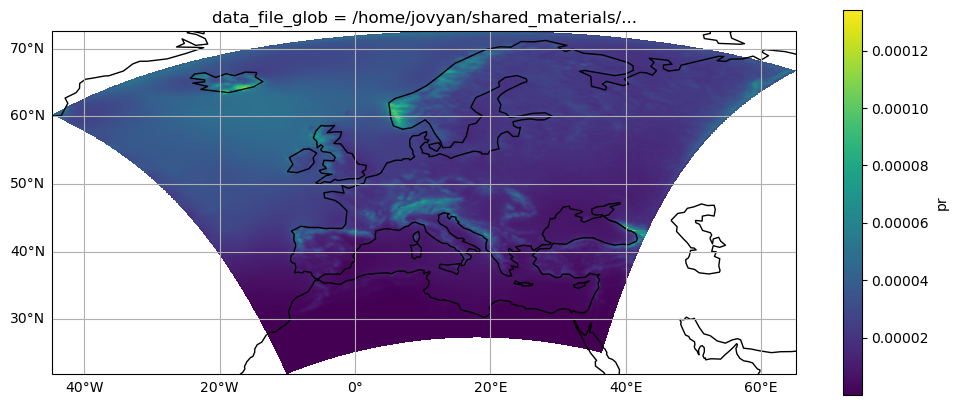

In [5]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": cartopy.crs.PlateCarree()}, figsize=(12, 5))

ds.pr.mean("time").plot(
    x="lon", y="lat", ax=ax, transform=cartopy.crs.PlateCarree(),
)

ax.coastlines()
ax.gridlines(draw_labels=["left", "bottom"])

## Select Kiel Bight precipitation and have a look

In [6]:
# set an xoak index
ds.xoak.set_index(["lon", "lat"], "sklearn_geo_balltree")

In [7]:
# xoak need xr.DataArray selectors
ds_kiel_bight = ds.xoak.sel(lat=xr.DataArray(lat_poi), lon=xr.DataArray(lon_poi))

# (lon, lat) will be from the nearest model data location, (lon_poi, lat_poi) are from the POI
ds_kiel_bight = ds_kiel_bight.assign_coords(lat_poi=lat_poi, lon_poi=lon_poi)

ds_kiel_bight

<xarray.Dataset> Size: 443kB
Dimensions:            (time: 36865)
Coordinates:
    data_file_glob     <U120 480B ...
    domain_resolution  <U6 24B ...
    gcm                <U13 52B ...
    lat                float64 8B dask.array<chunksize=(), meta=np.ndarray>
    lon                float64 8B dask.array<chunksize=(), meta=np.ndarray>
    rcm                <U17 68B ...
    rlat               float64 8B 4.125
    rlon               float64 8B -4.395
  * time               (time) object 295kB 1950-01-01 12:00:00 ... 2050-12-31...
    variable           <U2 8B ...
    lat_poi            float64 8B 54.64
    lon_poi            float64 8B 10.45
Data variables:
    pr                 (time) float32 147kB dask.array<chunksize=(36865,), meta=np.ndarray>
Attributes: (12/24)
    CORDEX_domain:                  EUR-11
    Conventions:                    CF-1.4
    c3s_disclaimer:                 This data has been produced in the contex...
    comment:                        CORDEX Europe RCM CCLM 0.11 deg EUR-11
    contact:                        klima.projektionen@dwd.de
    conventionsURL:                 http://www.cfconventions.org
    ...                             ...
    product:                        output
    project_id:                     CORDEX
    rcm_version_id:                 v1
    references:                     http://cordex.clm-community.eu/
    source:                         CLMcom-CCLM4-8-17
    tracking_id:                    hdl:21.14103/0c921fcc-a466-4c32-9e94-a81a...

Some annual statistics:

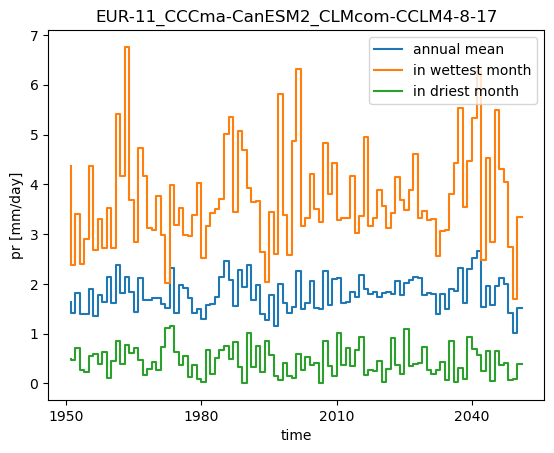

In [8]:
(ds_kiel_bight.pr * 3600 * 24).rename("pr [mm/day]").resample(time="1YE").mean().plot.step(label="annual mean")
(ds_kiel_bight.pr * 3600 * 24).rename("pr [mm/day]").resample(time="1ME").mean().resample(time="1YE").max().plot.step(label="in wettest month")
(ds_kiel_bight.pr * 3600 * 24).rename("pr [mm/day]").resample(time="1ME").mean().resample(time="1YE").min().plot.step(label="in driest month")
ax = plt.gca()
ax.legend(ncol=1)
ax.set_title("_".join(
    [ds_kiel_bight["domain_resolution"].data[()], ds_kiel_bight["gcm"].data[()], ds_kiel_bight["rcm"].data[()]]
));

## Transform to Pandas Dataframe

Pandas often is easier for time series data.

In [9]:
# Some datasets use rlon, rlat for the grid enumeration and some use x and y  :(
df_kiel_bight = ds_kiel_bight.drop_vars(["data_file_glob", "rlon", "rlat"]).to_dataframe()
df_kiel_bight

,domain_resolution,gcm,lat,lon,pr,rcm,variable,lat_poi,lon_poi
time,,,,,,,,,
1950-01-01 12:00:00,EUR-11,CCCma-CanESM2,54.649456,10.408697,4.781826e-05,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
1950-01-02 12:00:00,EUR-11,CCCma-CanESM2,54.649456,10.408697,3.781450e-05,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
1950-01-03 12:00:00,EUR-11,CCCma-CanESM2,54.649456,10.408697,7.049244e-07,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
1950-01-04 12:00:00,EUR-11,CCCma-CanESM2,54.649456,10.408697,5.649438e-06,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
1950-01-05 12:00:00,EUR-11,CCCma-CanESM2,54.649456,10.408697,5.807157e-06,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
...,...,...,...,...,...,...,...,...,...
2050-12-27 12:00:00,EUR-11,CCCma-CanESM2,54.649456,10.408697,0.000000e+00,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
2050-12-28 12:00:00,EUR-11,CCCma-CanESM2,54.649456,10.408697,2.122513e-05,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
2050-12-29 12:00:00,EUR-11,CCCma-CanESM2,54.649456,10.408697,5.416794e-10,CLMcom-CCLM4-8-17,pr,54.63526,10.449839


## Wrapped in a function

We want data frames in [tidy long form](https://seaborn.pydata.org/tutorial/data_structure.html#long-form-data) because they are easy to concatenate.

In [10]:
def get_time_series_data_frame_for_poi(
    lat_poi=None, lon_poi=None,
    catalog=None,
    domain_resolution="EUR-11", gcm="CCCma-CanESM2", rcm="CLMcom-CCLM4-8-17", variable="pr",
):
    ds = xr.open_zarr(
        Path(data_path)
        / catalog.loc[domain_resolution].loc[gcm].loc[rcm].loc[variable].zarr_name
    )

    ds = ds.where(~(ds.lon.isnull() & ds.lat.isnull()).compute(), drop=True)

    ds.xoak.set_index(["lon", "lat"], "sklearn_geo_balltree")

    ds_poi = ds.xoak.sel(lat=xr.DataArray(lat_poi), lon=xr.DataArray(lon_poi))
    ds_poi = ds_poi.assign_coords(lat_poi=lat_poi, lon_poi=lon_poi)
    if "rlon" in ds_poi:
        ds_poi = ds_poi.drop_vars(["rlon", "rlat", "data_file_glob"])
    elif "x" in ds_poi:
        ds_poi = ds_poi.drop_vars(["x", "y", "data_file_glob"])
    ds_poi = ds_poi.rename_vars({variable: "value"})

    return ds_poi.to_dataframe()

In [11]:
df_poi = get_time_series_data_frame_for_poi(
    lat_poi=lat_poi, lon_poi=lon_poi,
    catalog=catalog,
)
df_poi

,value,domain_resolution,gcm,lat,lon,rcm,variable,lat_poi,lon_poi
time,,,,,,,,,
1950-01-01 12:00:00,4.781826e-05,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
1950-01-02 12:00:00,3.781450e-05,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
1950-01-03 12:00:00,7.049244e-07,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
1950-01-04 12:00:00,5.649438e-06,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
1950-01-05 12:00:00,5.807157e-06,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
...,...,...,...,...,...,...,...,...,...
2050-12-27 12:00:00,0.000000e+00,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
2050-12-28 12:00:00,2.122513e-05,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,pr,54.63526,10.449839
2050-12-29 12:00:00,5.416794e-10,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,pr,54.63526,10.449839


## Extract all data for a POI

This will open all Zarr stores, find the respective location for the POI and then load the necessary chunks containing the POI.

Let's check the timing.

In [12]:
%%time

_df_list = []
for r in catalog.iterrows():
    domain_resolution, gcm, rcm, variable = r[0]
    _df_list.append(
        get_time_series_data_frame_for_poi(
            lat_poi=lat_poi, lon_poi=lon_poi,
            catalog=catalog,
            domain_resolution=domain_resolution, gcm=gcm, rcm=rcm, variable=variable,
        ).reset_index()
    )
df_poi_all_models = pd.concat(_df_list, ignore_index=True)
df_poi_all_models = df_poi_all_models.set_index("variable")
df_poi_all_models

CPU times: user 11.7 s, sys: 5.16 s, total: 16.9 s
Wall time: 18 s


,time,value,domain_resolution,gcm,lat,lon,rcm,lat_poi,lon_poi
variable,,,,,,,,,
pr,1950-01-01 12:00:00,0.000019,AFR-22,CCCma-CanESM2,42.349995,10.670015,CCCma-CanRCM4,54.63526,10.449839
pr,1950-01-02 12:00:00,0.000025,AFR-22,CCCma-CanESM2,42.349995,10.670015,CCCma-CanRCM4,54.63526,10.449839
pr,1950-01-03 12:00:00,0.000013,AFR-22,CCCma-CanESM2,42.349995,10.670015,CCCma-CanRCM4,54.63526,10.449839
pr,1950-01-04 12:00:00,0.000000,AFR-22,CCCma-CanESM2,42.349995,10.670015,CCCma-CanRCM4,54.63526,10.449839
pr,1950-01-05 12:00:00,0.000000,AFR-22,CCCma-CanESM2,42.349995,10.670015,CCCma-CanRCM4,54.63526,10.449839
...,...,...,...,...,...,...,...,...,...
tasmax,2050-12-27 12:00:00,282.529877,EUR-11,NCC-NorESM1-M,54.649455,10.408697,SMHI-RCA4,54.63526,10.449839
tasmax,2050-12-28 12:00:00,282.129578,EUR-11,NCC-NorESM1-M,54.649455,10.408697,SMHI-RCA4,54.63526,10.449839
tasmax,2050-12-29 12:00:00,283.060120,EUR-11,NCC-NorESM1-M,54.649455,10.408697,SMHI-RCA4,54.63526,10.449839


**_Note_** that we selected from both EUR-11 and AFR-22. But we can filter later:

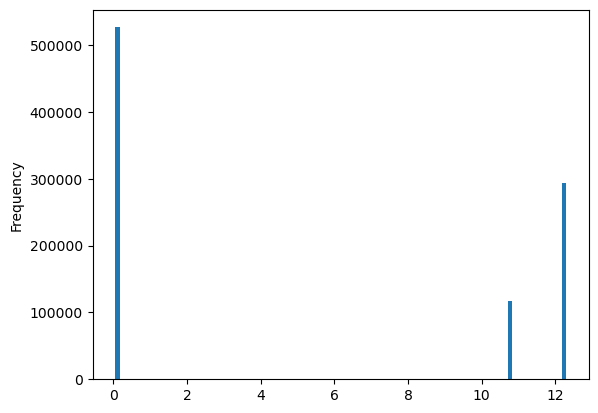

In [13]:
dlon_poi = df_poi_all_models.lon - df_poi_all_models.lon_poi
dlat_poi = df_poi_all_models.lat - df_poi_all_models.lat_poi
dist_degrees_poi = (
    ((df_poi_all_models.lon - df_poi_all_models.lon_poi)) ** 2  # should we be more careful about lon periodicity here!?
    + (df_poi_all_models.lat - df_poi_all_models.lat_poi) ** 2
) ** 0.5
dist_degrees_poi.plot.hist(bins=101);

In [14]:
too_far_away = dist_degrees_poi > 1
df_poi_good_models = df_poi_all_models.where(~too_far_away).dropna()
df_poi_good_models

,time,value,domain_resolution,gcm,lat,lon,rcm,lat_poi,lon_poi
variable,,,,,,,,,
pr,1950-01-01 12:00:00,4.781826e-05,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,54.63526,10.449839
pr,1950-01-02 12:00:00,3.781450e-05,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,54.63526,10.449839
pr,1950-01-03 12:00:00,7.049244e-07,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,54.63526,10.449839
pr,1950-01-04 12:00:00,5.649438e-06,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,54.63526,10.449839
pr,1950-01-05 12:00:00,5.807157e-06,EUR-11,CCCma-CanESM2,54.649456,10.408697,CLMcom-CCLM4-8-17,54.63526,10.449839
...,...,...,...,...,...,...,...,...,...
tasmax,2050-12-27 12:00:00,2.825299e+02,EUR-11,NCC-NorESM1-M,54.649455,10.408697,SMHI-RCA4,54.63526,10.449839
tasmax,2050-12-28 12:00:00,2.821296e+02,EUR-11,NCC-NorESM1-M,54.649455,10.408697,SMHI-RCA4,54.63526,10.449839
tasmax,2050-12-29 12:00:00,2.830601e+02,EUR-11,NCC-NorESM1-M,54.649455,10.408697,SMHI-RCA4,54.63526,10.449839


In [15]:
df_poi_good_models.loc["pr"].describe()

,value,lat,lon,lat_poi,lon_poi
count,2.780640e+05,278064.000000,278064.000000,2.780640e+05,2.780640e+05
mean,2.852002e-05,54.644839,10.434485,5.463526e+01,1.044984e+01
std,3.580374e-04,0.017967,0.043180,3.186079e-10,2.041038e-12
min,0.000000e+00,54.600540,10.408697,5.463526e+01,1.044984e+01
25%,2.712680e-07,54.649455,10.408697,5.463526e+01,1.044984e+01
50%,7.595504e-06,54.649456,10.408697,5.463526e+01,1.044984e+01
75%,3.517434e-05,54.649456,10.500000,5.463526e+01,1.044984e+01
max,1.871908e-01,54.663711,10.512683,5.463526e+01,1.044984e+01


In [16]:
df_poi_good_models.loc["tasmax"].describe()

,value,lat,lon,lat_poi,lon_poi
count,248864.000000,248864.000000,248864.000000,2.488640e+05,2.488640e+05
mean,283.897217,54.644297,10.437511,5.463526e+01,1.044984e+01
std,5.459858,0.018918,0.044677,2.592065e-10,1.688786e-11
min,263.471832,54.600540,10.408697,5.463526e+01,1.044984e+01
25%,279.488182,54.649455,10.408697,5.463526e+01,1.044984e+01
50%,283.450226,54.649456,10.408697,5.463526e+01,1.044984e+01
75%,288.717529,54.649456,10.500000,5.463526e+01,1.044984e+01
max,302.399139,54.663711,10.512683,5.463526e+01,1.044984e+01


## Fix calendars

There's a few different calendars in here. We even have one with a Februar 29th in 1950.
We "fix" them by first converting to "YYYY-MM-DD HH:mm" (ignoring any time zome and calendar convention) and then coercing them to the real leapyear calendar omitting all data which don't fit.

In [17]:
# a bit hacky: There's some weird calendars in there (some leap, some noleap, some wrongleap?!)
df_poi_good_models["time_fixed"] = pd.to_datetime(df_poi_good_models.time.apply(str), errors="coerce")
df_poi_good_models = df_poi_good_models.dropna()

## Some PR and TASMAX stats

In [18]:
pr_median = df_poi_good_models.loc["pr"].sort_values(by="time_fixed").set_index("time_fixed").value.resample("1YE").median()
pr_q99 = df_poi_good_models.loc["pr"].sort_values(by="time_fixed").set_index("time_fixed").value.resample("1YE").quantile(0.99)
pr_q01 = df_poi_good_models.loc["pr"].sort_values(by="time_fixed").set_index("time_fixed").value.resample("1YE").quantile(0.01)
pr_counts = df_poi_good_models.loc["pr"].sort_values(by="time_fixed").set_index("time_fixed").value.resample("1YE").count()

<Axes: xlabel='time_fixed'>

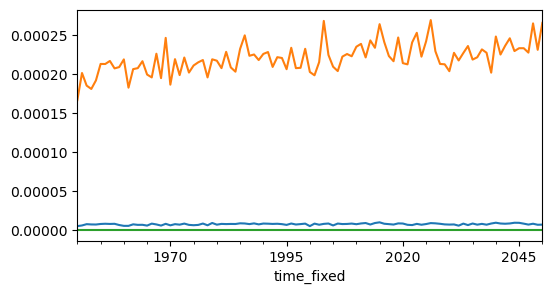

In [19]:
ax = pr_median.plot(figsize=(6, 3))
pr_q99.plot(ax=ax)
pr_q01.plot(ax=ax)

In [20]:
tasmax_median = df_poi_good_models.loc["tasmax"].sort_values(by="time_fixed").set_index("time_fixed").value.resample("1YE").median()
tasmax_q99 = df_poi_good_models.loc["tasmax"].sort_values(by="time_fixed").set_index("time_fixed").value.resample("1YE").quantile(0.99)
tasmax_q01 = df_poi_good_models.loc["tasmax"].sort_values(by="time_fixed").set_index("time_fixed").value.resample("1YE").quantile(0.01)
tasmax_counts = df_poi_good_models.loc["tasmax"].sort_values(by="time_fixed").set_index("time_fixed").value.resample("1YE").count()

<Axes: xlabel='time_fixed'>

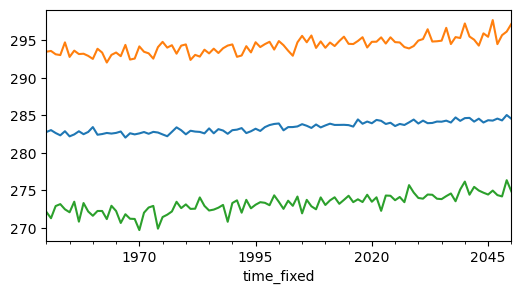

In [21]:
ax = tasmax_median.plot(figsize=(6, 3))
tasmax_q99.plot(ax=ax)
tasmax_q01.plot(ax=ax)

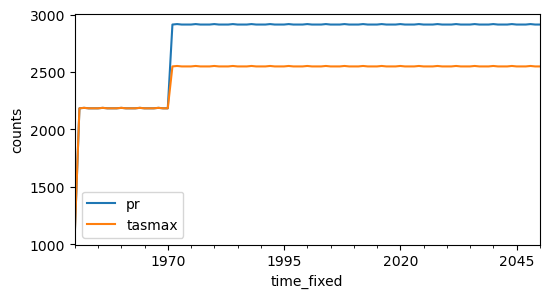

In [23]:
ax = pr_counts.plot(label="pr", figsize=(6, 3), grid=True)
tasmax_counts.plot(label="tasmax", ax=ax)
ax.legend()
ax.set_ylabel("counts");